## AA214 Homework 6

### Problem 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [2]:
# Computation of ARL and W(x/t)
def W_x(WL,WR,x_t):
    rhoL,uL,EL,PL,hL = Wtovar(WL)
    rhoR,uR,ER,PR,hR = Wtovar(WR)
    vRL = (np.sqrt(rhoL)*uL+np.sqrt(rhoR)*uR)/(np.sqrt(rhoL)+np.sqrt(rhoR))
    hRL = (np.sqrt(rhoL)*hL+np.sqrt(rhoR)*hR)/(np.sqrt(rhoL)+np.sqrt(rhoR))
    ARL = A_mat(hRL,vRL,1.4)
    a,b = np.linalg.eig(ARL)
    dW = WR-WL
    dS = np.matmul(np.linalg.inv(b),dW)
    if x_t<a[1]:
        W = WL
    elif x_t<a[0]:
        W = WL+np.array([0,dS[1],0])
    elif x_t<a[2]:
        W = WR-np.array([0,0,dS[2]])
    else:
        W = WR
    return ARL,W

In [3]:
# Extraction of physical quantities from W
def Wtovar(W):
    gamma = 1.4
    rho = W[0]
    v = W[1]/W[0]
    E = W[2]
    P = (E-rho*v*v/2)*(gamma-1)
    h = (E+P)/rho
    return rho,v,E,P,h

In [4]:
# ARL matrix
def A_mat(h,v,g):
    return np.array([[0,1,0], [(g-3)*v**2/2,(3-g)*v,g-1],
            [-v*h+(g-1)*v**3/2,h-(g-1)*v**2,g*v]])

In [5]:
t = 0.01
pL = 100000
rhoL = 1
uL = 100
pR = 10000
rhoR = 0.125
uR = 50
gamma = 1.4
EL = pL/(gamma-1)+rhoL*uL**2/2
ER = pR/(gamma-1)+rhoR*uR**2/2

hL = (EL+pL)/rhoL
hR = (ER+pR)/rhoR
vRL = (np.sqrt(rhoL)*uL+np.sqrt(rhoR)*uR)/(np.sqrt(rhoL)+np.sqrt(rhoR))
hRL = (np.sqrt(rhoL)*hL+np.sqrt(rhoR)*hR)/(np.sqrt(rhoL)+np.sqrt(rhoR))
WL = np.array([rhoL,rhoL*uL,EL])
WR = np.array([rhoR,rhoR*uR,ER])
x = np.linspace(-10,10,101)
t = 0.01
rho_x = np.zeros_like(x)
u_x = np.zeros_like(x)
P_x = np.zeros_like(x)
for i in range(len(x)):
    p,q = W_x(WL,WR,x[i]/t)
    rho,v,E,P,h = Wtovar(q)
    rho_x[i] = rho
    u_x[i] = v
    P_x[i] = P

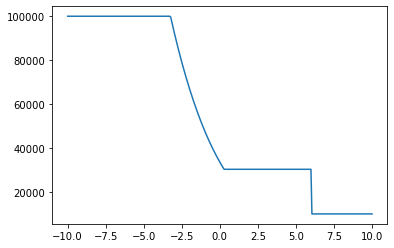

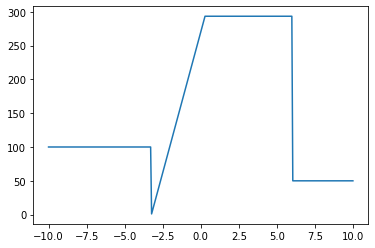

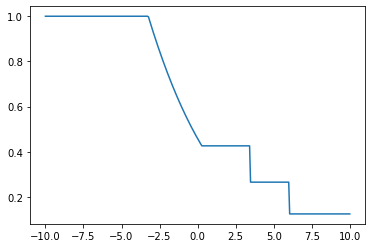

In [6]:
import sodshock
import matplotlib.pyplot as plt

gamma = 1.4
dustFrac = 0.0
npts = 320
t = 0.01
left_state = (100000,1,100)
right_state = (10000, 0.125, 50.)

positions, regions, values = sodshock.solve(left_state=left_state, \
    right_state=right_state, geometry=(-10., 10., 0.5), t=t, 
    gamma=gamma, npts=npts, dustFrac=dustFrac)

plt.plot(values['x'],values['p'])
plt.show()

plt.plot(values['x'],values['u'])
plt.show()

plt.plot(values['x'],values['rho'])
plt.show()

In [8]:
positions

{'Head of Rarefaction': -3.2416573867739413,
 'Foot of Rarefaction': 0.2777778547205719,
 'Contact Discontinuity': 3.4328627012454285,
 'Shock': 6.040802928535007}

### Problem 2a

In [646]:
def sw(p1,rho1,u1,l):
    n = len(u1)-1
    u = u1[:n]
    rho = rho1[:n]
    p = p1[:n] 
    c = np.sqrt(g*p/rho)

    M = u/c
    F_plus = np.zeros((3,n))
    F_minus = np.zeros((3,n))
    F = np.array([rho*u,rho*u**2+p,g*p*u/(g-1)+rho*u**3/2])
    F1 = (rho*(u+c)/(2*g))*np.array([np.ones(n),u+c,u**2/2+c**2/(g-1)+c*u])
    F2 = (g-1)*rho*u*np.array([np.ones(n),u,u**2/2])/g
    F3 = rho*(u-c)*np.array([np.ones(n),u-c,u**2/2+c**2/(g-1)-c*u])/(2*g)
    for i in range(len(M)):
        if M[i]<=-1:
            F_minus[:,i] = F[:,i]
        elif M[i]>-1 and M[i]<=0:
            F_plus[:,i] = F1[:,i]
            F_minus[:,i] = F2[:,i]+F3[:,i]
        elif M[i]>0 and M[i]<=1:
            F_plus[:,i] = F2[:,i]+F1[:,i]
            F_minus[:,i] = F3[:,i]
        else:
            F_plus[:,i] = F[:,i]
    
    W = np.array([rho1,rho1*u1,p1/(g-1)+rho1*u1**2/2])
    W1 = W.copy()
    A = F_minus.copy()
    A[:,:n-1] = F_minus[:,1:]
    A[:,n-1] = F_minus[:,n-1]
    W1[:,1:n] = W[:,1:n] - l*F_plus[:,1:n] + l*F_plus[:,:n-1] + l*F_minus[:,1:n] - l*A[:,1:]
    rho_new = W1[0,:]
    u_new = W1[1,:]/W1[0,:]
    p_new = (g-1)*(W1[2,:]-rho_new*u_new**2/2)
    return p_new,rho_new,u_new
    

<ipython-input-599-9dadcd78b376>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,1,box_aspect=1)
<ipython-input-599-9dadcd78b376>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,2,box_aspect=1)
<ipython-input-599-9dadcd78b376>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance 

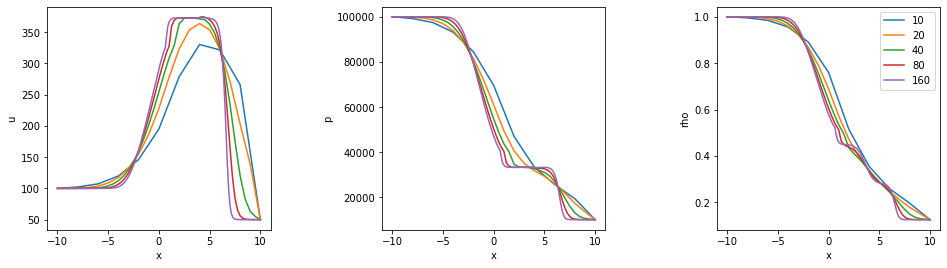

In [599]:
n_arr = np.array([10,20,40,80,160])
plt.figure(figsize=(16, 6))
for j in range(len(n_arr)):
    n = n_arr[j]
    g = 1.4
    x = np.linspace(-10,10,n+1)
    x1 = (x+10/n)[:n]
    p = 1e5*np.ones_like(x)
    rho = np.ones_like(x)
    u = 100*np.ones_like(x)
    for i in range(len(x)):
        if x[i]>0:
            p[i] = 1e4
            rho[i] = 0.125
            u[i] = 50
    dx = 20/n
    t = 0
    l = 0.0001
    while(t<0.01):
        t += dx*l
        p,rho,u = sw(p,rho,u,l)
    plt.subplot(1,3,1,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.plot(x,u,label=n)
    plt.subplot(1,3,2,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('p')
    plt.plot(x,p,label=n)
    plt.subplot(1,3,3,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('rho')
    plt.plot(x,rho,label=n)
plt.subplots_adjust(wspace=0.5)
plt.legend()
plt.show()

### Problem 3a

<ipython-input-654-cb0a7c6fda4a>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,1,box_aspect=1)
<ipython-input-654-cb0a7c6fda4a>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,2,box_aspect=1)
<ipython-input-654-cb0a7c6fda4a>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance 

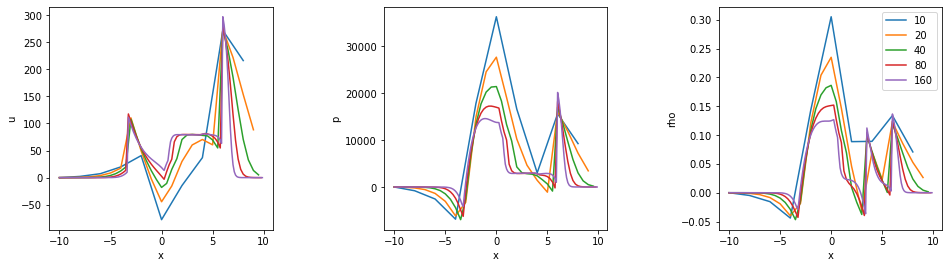

In [654]:
n_arr = np.array([10,20,40,80,160])
plt.figure(figsize=(16, 6))
for j in range(len(n_arr)):
    n = n_arr[j]
    g = 1.4
    x = np.linspace(-10,10,n+1)
    x1 = (x+10/n)[:n]
    p = 1e5*np.ones_like(x)
    rho = np.ones_like(x)
    u = 100*np.ones_like(x)
    for i in range(len(x)):
        if x[i]>0:
            p[i] = 1e4
            rho[i] = 0.125
            u[i] = 50
    dx = 20/n
    t = 0
    l = 0.0001
    while(t<0.01):
        t += dx*l
        p,rho,u = sw(p,rho,u,l)
    plt.subplot(1,3,1,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.plot(x[:n],u[:n]-values['u'][::int(320/n)],label=n)
    plt.subplot(1,3,2,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('p')
    plt.plot(x[:n],p[:n]-values['p'][::int(320/n)],label=n)
    plt.subplot(1,3,3,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('rho')
    plt.plot(x[:n],rho[:n]-values['rho'][::int(320/n)],label=n)
plt.subplots_adjust(wspace=0.5)
plt.legend()
plt.show()

### Problem 2b

In [286]:
def roe(p1,rho1,u1,x,l):
    n = len(u1)-1
    u = u1[:n]
    rho = rho1[:n]
    p = p1[:n] 
#     n = len(u1)
#     u = u1.copy()
#     rho = rho1.copy()
#     p = p1.copy()
    c = np.sqrt(g*p/rho)
    F = np.array([rho1*u1,rho1*u1**2+p1,g*p1*u1/(g-1)+rho1*u1**3/2])
    W = np.array([rho1,rho1*u1,p1/(g-1)+rho1*u1**2/2])
    W1 = W.copy()
    F1 = F.copy()
    
    for i in range(n-1):
        rhoL,uL,EL,PL,hL = Wtovar(W[:,i])
        rhoR,uR,ER,PR,hR = Wtovar(W[:,i+1])
        vRL = (np.sqrt(rhoL)*uL+np.sqrt(rhoR)*uR)/(np.sqrt(rhoL)+np.sqrt(rhoR))
        hRL = (np.sqrt(rhoL)*hL+np.sqrt(rhoR)*hR)/(np.sqrt(rhoL)+np.sqrt(rhoR))
#         q1,q2 = W_x(W[:,i-1],W[:,i],x[i]/t)
        ARL = A_mat(hRL,vRL,1.4)
#         print(i,hRL,vRL)
        a,b = np.linalg.eig(ARL)
        ARL_mod = np.matmul(b,np.matmul(np.diag(np.abs(a)),np.linalg.inv(b)))
#         ARL_plus = (ARL+ARL_mod)/2
#         ARL_minus = (ARL-ARL_mod)/2
#         rho,u,E,p,h = Wtovar(q2)
        F1[:,i] = (F[:,i]+F[:,i+1])/2 - np.matmul(ARL_mod,W[:,i+1]-W[:,i])/2
#         F1[:,i] = (F[:,i-1]+F[:,i])/2 - q2/2
#         F1[:,i] = (F[:,i-1]+F[:,i])/2 - np.matmul(ARL_plus,W[:,i]-W[:,i-1])/2 + np.matmul(ARL_mod,W[:,i]-W[:,i-1])/2
    W1[:,1:] = W[:,1:] - l*(F1[:,1:]-F1[:,:n])
    rho_new = W1[0,:]
    u_new = W1[1,:]/W1[0,:]
    p_new = (g-1)*(W1[2,:]-rho_new*u_new**2/2)
    return p_new,rho_new,u_new
    

<ipython-input-602-413cd24da6d9>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,1,box_aspect=1)
<ipython-input-602-413cd24da6d9>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,2,box_aspect=1)
<ipython-input-602-413cd24da6d9>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance 

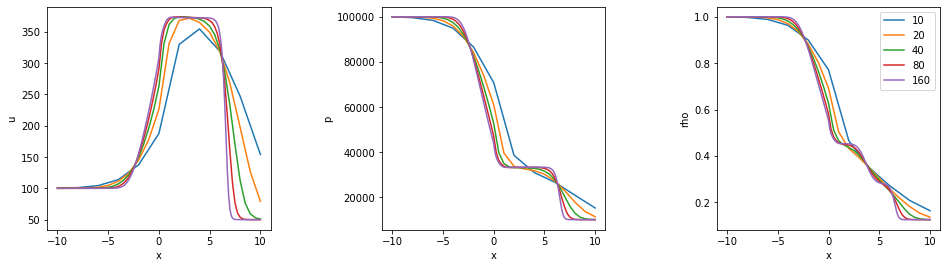

In [602]:
n_arr = np.array([10,20,40,80,160])
plt.figure(figsize=(16, 6))
for j in range(len(n_arr)):
    n = n_arr[j]
    g = 1.4
    x = np.linspace(-10,10,n+1)
    x1 = (x+10/n)[:n]
    p = 1e5*np.ones_like(x)
    rho = np.ones_like(x)
    u = 100*np.ones_like(x)
    for i in range(len(x)):
        if x[i]>0:
            p[i] = 1e4
            rho[i] = 0.125
            u[i] = 50
    dx = 20/n
    t = 0
    l = 0.0001
    while(t<0.01):
        t += dx*l
        p,rho,u = roe(p,rho,u,x1,l)
    plt.subplot(1,3,1,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.plot(x,u,label=n)
    plt.subplot(1,3,2,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('p')
    plt.plot(x,p,label=n)
    plt.subplot(1,3,3,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('rho')
    plt.plot(x,rho,label=n)
plt.subplots_adjust(wspace=0.5)
plt.legend()
plt.show()

### Problem 3b

<ipython-input-656-a9d9bc606269>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,1,box_aspect=1)
<ipython-input-656-a9d9bc606269>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,2,box_aspect=1)
<ipython-input-656-a9d9bc606269>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance 

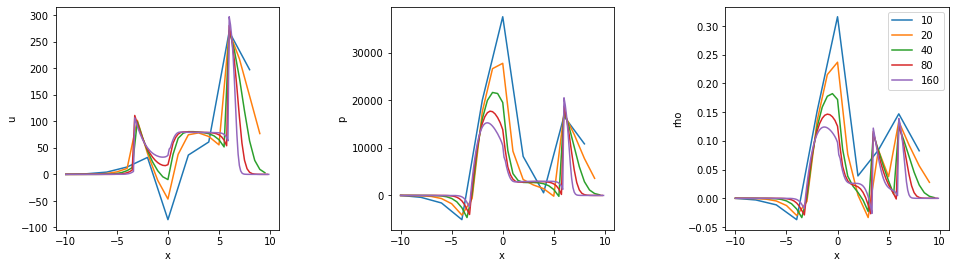

In [656]:
n_arr = np.array([10,20,40,80,160])
plt.figure(figsize=(16, 6))
for j in range(len(n_arr)):
    n = n_arr[j]
    g = 1.4
    x = np.linspace(-10,10,n+1)
    x1 = (x+10/n)[:n]
    p = 1e5*np.ones_like(x)
    rho = np.ones_like(x)
    u = 100*np.ones_like(x)
    for i in range(len(x)):
        if x[i]>0:
            p[i] = 1e4
            rho[i] = 0.125
            u[i] = 50
    dx = 20/n
    t = 0
    l = 0.0001
    while(t<0.01):
        t += dx*l
        p,rho,u = roe(p,rho,u,x1,l)
    plt.subplot(1,3,1,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.plot(x[:n],u[:n]-values['u'][::int(320/n)],label=n)
    plt.subplot(1,3,2,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('p')
    plt.plot(x[:n],p[:n]-values['p'][::int(320/n)],label=n)
    plt.subplot(1,3,3,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('rho')
    plt.plot(x[:n],rho[:n]-values['rho'][::int(320/n)],label=n)
plt.subplots_adjust(wspace=0.5)
plt.legend()
plt.show()

### Problem 2c

In [603]:
def phi_mp(u1):
    n = len(u1)-1
    r_p = np.zeros(n)
    phi_p = np.zeros(n)
    r_m = np.zeros(n)
    phi_m = np.zeros(n)
    for i in range(1,n):
        a = (u1[i+1]-u1[i])
        b = (u1[i]-u1[i-1])
        if b==0:
            if a==0:
                r_m[i] = 1
            else:
                r_m[i] = 2
        else:
            r_m[i] = a/b
        if a==0:
            if b==0:
                r_p[i] = 1
            else:
                r_p[i] = 2
        else:
            r_p[i] = b/a
        if r_m[i]>=0:
            phi_p[i] = 2*r_p[i]/(1+r_p[i])
        if r_p[i]>=0:
            phi_m[i] = 2*r_m[i]/(1+r_m[i])
    return phi_m,phi_p

In [613]:
def sw_2nd(p1,rho1,u1,l):
    n = len(u1)-1
    phi_m,phi_p = phi_mp(u1)
    u_p = u1[1:]+phi_p*(u1[1:]-u1[:n])/2
    u_m = u1[:n]-phi_m*(u1[1:]-u1[:n])/2
    phi_m,phi_p = phi_mp(rho1)
    rho_p = rho1[1:]+phi_p*(rho1[1:]-rho1[:n])/2
    rho_m = rho1[:n]-phi_m*(rho1[1:]-rho1[:n])/2
    phi_m,phi_p = phi_mp(p1)
    p_p = p1[1:]+phi_p*(p1[1:]-p1[:n])/2
    p_m = p1[:n]-phi_m*(p1[1:]-p1[:n])/2
    c_p = np.sqrt(g*p_p/rho_p)
    c_m = np.sqrt(g*p_m/rho_m)

    M_p = u_p/c_p
    M_m = u_m/c_m
    F_plus_p = np.zeros((3,n))
    F_minus_p = np.zeros((3,n))
    F_plus_m = np.zeros((3,n))
    F_minus_m = np.zeros((3,n))
    F_p = np.array([rho_p*u_p,rho_p*u_p**2+p_p,g*p_p*u_p/(g-1)+rho_p*u_p**3/2])
    F1_p = (rho_p*(u_p+c_p)/(2*g))*np.array([np.ones(n),u_p+c_p,u_p**2/2+c_p**2/(g-1)+c_p*u_p])
    F2_p = (g-1)*rho_p*u_p*np.array([np.ones(n),u_p,u_p**2/2])/g
    F3_p = rho_p*(u_p-c_p)*np.array([np.ones(n),u_p-c_p,u_p**2/2+c_p**2/(g-1)-c_p*u_p])/(2*g)
    
    F_m = np.array([rho_m*u_m,rho_m*u_m**2+p_m,g*p_m*u_m/(g-1)+rho_m*u_m**3/2])
    F1_m = (rho_m*(u_m+c_m)/(2*g))*np.array([np.ones(n),u_m+c_m,u_m**2/2+c_m**2/(g-1)+c_m*u_m])
    F2_m = (g-1)*rho_m*u_m*np.array([np.ones(n),u_m,u_m**2/2])/g
    F3_m = rho_m*(u_m-c_m)*np.array([np.ones(n),u_m-c_m,u_m**2/2+c_m**2/(g-1)-c_m*u_m])/(2*g)
    for i in range(len(M_p)):
        if M_p[i]<=-1:
            F_minus_p[:,i] = F_p[:,i]
        elif M_p[i]>-1 and M_p[i]<=0:
            F_plus_p[:,i] = F1_p[:,i]
            F_minus_p[:,i] = F2_p[:,i]+F3_p[:,i]
        elif M_p[i]>0 and M_p[i]<=1:
            F_plus_p[:,i] = F2_p[:,i]+F1_p[:,i]
            F_minus_p[:,i] = F3_p[:,i]
        else:
            F_plus_p[:,i] = F_p[:,i]
            
    for i in range(len(M_m)):
        if M_m[i]<=-1:
            F_minus_m[:,i] = F_m[:,i]
        elif M_m[i]>-1 and M_m[i]<=0:
            F_plus_m[:,i] = F1_m[:,i]
            F_minus_m[:,i] = F2_m[:,i]+F3_m[:,i]
        elif M_m[i]>0 and M_m[i]<=1:
            F_plus_m[:,i] = F2_m[:,i]+F1_m[:,i]
            F_minus_m[:,i] = F3_m[:,i]
        else:
            F_plus_m[:,i] = F_m[:,i]
    
    W = np.array([rho1,rho1*u1,p1/(g-1)+rho1*u1**2/2])
    W1 = W.copy()
    F_plus = F_plus_p+F_plus_m
    F_minus = F_minus_p+F_minus_m
    A = F_minus_p.copy()
    A[:,:n-1] = F_minus_p[:,1:]
    A[:,n-1] = F_minus_p[:,n-1]
    W1[:,1:n] = W[:,1:n] - l*F_plus_m[:,1:n] + l*F_plus_p[:,:n-1] + l*F_minus_m[:,1:n] - l*A[:,1:]
    rho_new = W1[0,:]
    u_new = W1[1,:]/W1[0,:]
    p_new = (g-1)*(W1[2,:]-rho_new*u_new**2/2)
    return p_new,rho_new,u_new
    

<ipython-input-613-3fd009befc3b>:48: RuntimeWarning: invalid value encountered in sqrt
  c_p = np.sqrt(g*p_p/rho_p)
<ipython-input-613-3fd009befc3b>:48: RuntimeWarning: invalid value encountered in sqrt
  c_p = np.sqrt(g*p_p/rho_p)
<ipython-input-657-50e70654646a>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,1,box_aspect=1)
<ipython-input-657-50e70654646a>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pl

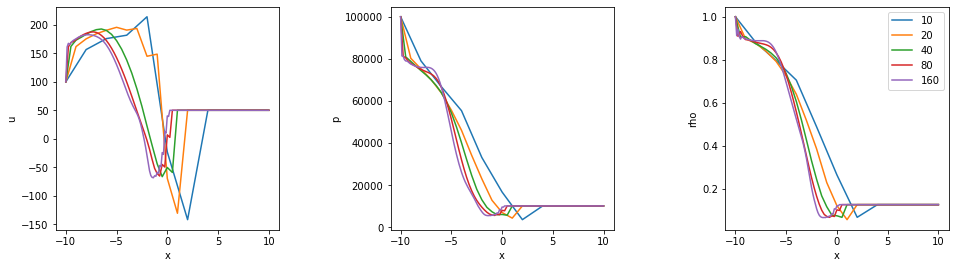

In [657]:
n_arr = np.array([10,20,40,80,160])
plt.figure(figsize=(16, 6))
for j in range(len(n_arr)):
    n = n_arr[j]
    g = 1.4
    x = np.linspace(-10,10,n+1)
    x1 = (x+10/n)[:n]
    p = 1e5*np.ones_like(x)
    rho = np.ones_like(x)
    u = 100*np.ones_like(x)
    for i in range(len(x)):
        if x[i]>0:
            p[i] = 1e4
            rho[i] = 0.125
            u[i] = 50
    dx = 20/n
    t = 0
    l = 0.0001
    while(t<0.01):
        t += dx*l
        p,rho,u = sw_2nd(p,rho,u,l)
    plt.subplot(1,3,1,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.plot(x,u,label=n)
    plt.subplot(1,3,2,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('p')
    plt.plot(x,p,label=n)
    plt.subplot(1,3,3,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('rho')
    plt.plot(x,rho,label=n)
plt.subplots_adjust(wspace=0.5)
plt.legend()
plt.show()

### Problem 3c

<ipython-input-613-3fd009befc3b>:48: RuntimeWarning: invalid value encountered in sqrt
  c_p = np.sqrt(g*p_p/rho_p)
<ipython-input-613-3fd009befc3b>:48: RuntimeWarning: invalid value encountered in sqrt
  c_p = np.sqrt(g*p_p/rho_p)
<ipython-input-658-d9f121f8fb8f>:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,1,box_aspect=1)
<ipython-input-658-d9f121f8fb8f>:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pl

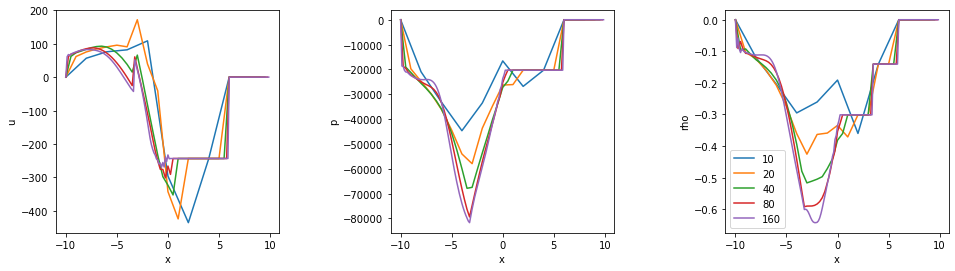

In [658]:
n_arr = np.array([10,20,40,80,160])
plt.figure(figsize=(16, 6))
for j in range(len(n_arr)):
    n = n_arr[j]
    g = 1.4
    x = np.linspace(-10,10,n+1)
    x1 = (x+10/n)[:n]
    p = 1e5*np.ones_like(x)
    rho = np.ones_like(x)
    u = 100*np.ones_like(x)
    for i in range(len(x)):
        if x[i]>0:
            p[i] = 1e4
            rho[i] = 0.125
            u[i] = 50
    dx = 20/n
    t = 0
    l = 0.0001
    while(t<0.01):
        t += dx*l
        p,rho,u = sw_2nd(p,rho,u,l)
    plt.subplot(1,3,1,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.plot(x[:n],u[:n]-values['u'][::int(320/n)],label=n)
    plt.subplot(1,3,2,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('p')
    plt.plot(x[:n],p[:n]-values['p'][::int(320/n)],label=n)
    plt.subplot(1,3,3,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('rho')
    plt.plot(x[:n],rho[:n]-values['rho'][::int(320/n)],label=n)
plt.subplots_adjust(wspace=0.5)
plt.legend()
plt.show()

### Problem 2d

In [663]:
def roe_2nd(p1,rho1,u1,x,l):
    n = len(u1)-1
    
    phi_m,phi_p = phi_mp(u1)
    u_p = u1[1:]+phi_p*(u1[1:]-u1[:n])/2
    u_m = u1[:n]-phi_m*(u1[1:]-u1[:n])/2
    phi_m,phi_p = phi_mp(rho1)
    rho_p = rho1[1:]+phi_p*(rho1[1:]-rho1[:n])/2
    rho_m = rho1[:n]-phi_m*(rho1[1:]-rho1[:n])/2
    phi_m,phi_p = phi_mp(p1)
    p_p = p1[1:]+phi_p*(p1[1:]-p1[:n])/2
    p_m = p1[:n]-phi_m*(p1[1:]-p1[:n])/2
    
    c_p = np.sqrt(g*p_p/rho_p)
    c_m = np.sqrt(g*p_m/rho_m)
    
    F_p = np.array([rho_p*u_p,rho_p*u_p**2+p_p,g*p_p*u_p/(g-1)+rho_p*u_p**3/2])
    F_m = np.array([rho_m*u_m,rho_m*u_m**2+p_m,g*p_m*u_m/(g-1)+rho_m*u_m**3/2])
    
#     F = np.array([rho*u,rho*u**2+p,g*p*u/(g-1)+rho*u**3/2])
    W_p = np.array([rho_p,rho_p*u_p,p_p/(g-1)+rho_p*u_p**2/2])
    W_m = np.array([rho_m,rho_m*u_m,p_m/(g-1)+rho_m*u_m**2/2])
    F1 = np.array([rho1*u1,rho1*u1**2+p1,g*p1*u1/(g-1)+rho1*u1**3/2])
    F2 = F1.copy()
    F1_p = F_p.copy()
    F1_m = F_m.copy()
    W1 = np.array([rho1,rho1*u1,p1/(g-1)+rho1*u1**2/2])
    W2 = W1.copy()
    
    for i in range(n-1):
        rhoL,uL,EL,PL,hL = Wtovar(W_p[:,i])
        rhoR,uR,ER,PR,hR = Wtovar(W_p[:,i+1])
        vRL = (np.sqrt(rhoL)*uL+np.sqrt(rhoR)*uR)/(np.sqrt(rhoL)+np.sqrt(rhoR))
        hRL = (np.sqrt(rhoL)*hL+np.sqrt(rhoR)*hR)/(np.sqrt(rhoL)+np.sqrt(rhoR))
#         q1,q2 = W_x(W[:,i-1],W[:,i],x[i]/t)
        ARL = A_mat(hRL,vRL,1.4)
#         print(i,hRL,vRL)
        a,b = np.linalg.eig(ARL)
        ARL_mod_p = np.matmul(b,np.matmul(np.diag(np.abs(a)),np.linalg.inv(b)))
        
        rhoL,uL,EL,PL,hL = Wtovar(W_m[:,i])
        rhoR,uR,ER,PR,hR = Wtovar(W_m[:,i+1])
        vRL = (np.sqrt(rhoL)*uL+np.sqrt(rhoR)*uR)/(np.sqrt(rhoL)+np.sqrt(rhoR))
        hRL = (np.sqrt(rhoL)*hL+np.sqrt(rhoR)*hR)/(np.sqrt(rhoL)+np.sqrt(rhoR))
#         q1,q2 = W_x(W[:,i-1],W[:,i],x[i]/t)
        ARL = A_mat(hRL,vRL,1.4)
#         print(i,hRL,vRL)
        a,b = np.linalg.eig(ARL)
        ARL_mod_m = np.matmul(b,np.matmul(np.diag(np.abs(a)),np.linalg.inv(b)))
        
#         ARL_plus = (ARL+ARL_mod)/2
#         ARL_minus = (ARL-ARL_mod)/2
#         rho,u,E,p,h = Wtovar(q2)
        F1_p[:,i] = (F_p[:,i]+F_p[:,i+1])/2 - np.matmul(ARL_mod_p,W_p[:,i+1]-W_p[:,i])/2
        F1_m[:,i] = (F_m[:,i]+F_m[:,i+1])/2 - np.matmul(ARL_mod_m,W_m[:,i+1]-W_m[:,i])/2
#         F1[:,i] = (F[:,i-1]+F[:,i])/2 - q2/2
#         F1[:,i] = (F[:,i-1]+F[:,i])/2 - np.matmul(ARL_plus,W[:,i]-W[:,i-1])/2 + np.matmul(ARL_mod,W[:,i]-W[:,i-1])/2
#     F1[:,n-1] = F[:,n-1]
#     W1[:,0] = W[:,0]
    W2[:,1:n] = W1[:,1:n] - l*(F2[:,1:n]-F2[:,:n-1])
    rho_new = W2[0,:]
    u_new = W2[1,:]/W2[0,:]
    p_new = (g-1)*(W2[2,:]-rho_new*u_new**2/2)
    return p_new,rho_new,u_new
    

<ipython-input-663-df2c74640a7a>:14: RuntimeWarning: invalid value encountered in sqrt
  c_p = np.sqrt(g*p_p/rho_p)
<ipython-input-663-df2c74640a7a>:15: RuntimeWarning: invalid value encountered in sqrt
  c_m = np.sqrt(g*p_m/rho_m)
<ipython-input-663-df2c74640a7a>:55: ComplexWarning: Casting complex values to real discards the imaginary part
  F1_m[:,i] = (F_m[:,i]+F_m[:,i+1])/2 - np.matmul(ARL_mod_m,W_m[:,i+1]-W_m[:,i])/2
<ipython-input-663-df2c74640a7a>:54: ComplexWarning: Casting complex values to real discards the imaginary part
  F1_p[:,i] = (F_p[:,i]+F_p[:,i+1])/2 - np.matmul(ARL_mod_p,W_p[:,i+1]-W_p[:,i])/2
<ipython-input-663-df2c74640a7a>:14: RuntimeWarning: invalid value encountered in sqrt
  c_p = np.sqrt(g*p_p/rho_p)
<ipython-input-663-df2c74640a7a>:15: RuntimeWarning: invalid value encountered in sqrt
  c_m = np.sqrt(g*p_m/rho_m)
<ipython-input-663-df2c74640a7a>:55: ComplexWarning: Casting complex values to real discards the imaginary part
  F1_m[:,i] = (F_m[:,i]+F_m[:,i+1]

LinAlgError: Array must not contain infs or NaNs

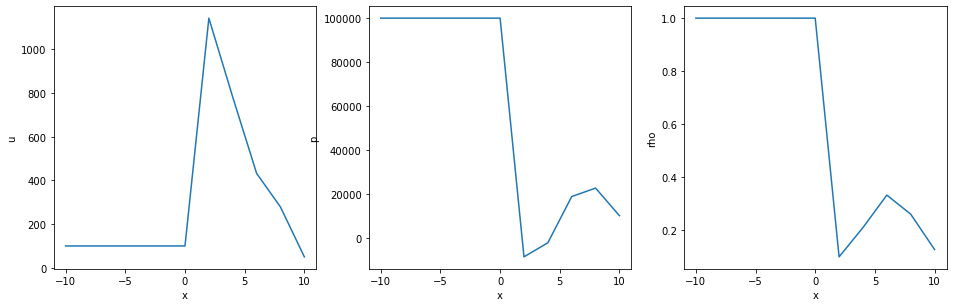

In [667]:
n_arr = np.array([10,20,40,80,160])
plt.figure(figsize=(16, 6))
for j in range(len(n_arr)):
    n = n_arr[j]
    g = 1.4
    x = np.linspace(-10,10,n+1)
    x1 = (x+10/n)[:n]
    p = 1e5*np.ones_like(x)
    rho = np.ones_like(x)
    u = 100*np.ones_like(x)
    for i in range(len(x)):
        if x[i]>0:
            p[i] = 1e4
            rho[i] = 0.125
            u[i] = 50
    dx = 20/n
    t = 0
    l = 0.0001
    while(t<0.01):
        t += dx*l
        p,rho,u = roe_2nd(p,rho,u,x1,l)
    plt.subplot(1,3,1,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.plot(x,u,label=n)
    plt.subplot(1,3,2,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('p')
    plt.plot(x,p,label=n)
    plt.subplot(1,3,3,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('rho')
    plt.plot(x,rho,label=n)
plt.subplots_adjust(wspace=0.5)
plt.legend()
plt.show()

### Problem 3d

<ipython-input-663-df2c74640a7a>:14: RuntimeWarning: invalid value encountered in sqrt
  c_p = np.sqrt(g*p_p/rho_p)
<ipython-input-663-df2c74640a7a>:15: RuntimeWarning: invalid value encountered in sqrt
  c_m = np.sqrt(g*p_m/rho_m)
<ipython-input-663-df2c74640a7a>:55: ComplexWarning: Casting complex values to real discards the imaginary part
  F1_m[:,i] = (F_m[:,i]+F_m[:,i+1])/2 - np.matmul(ARL_mod_m,W_m[:,i+1]-W_m[:,i])/2
<ipython-input-663-df2c74640a7a>:54: ComplexWarning: Casting complex values to real discards the imaginary part
  F1_p[:,i] = (F_p[:,i]+F_p[:,i+1])/2 - np.matmul(ARL_mod_p,W_p[:,i+1]-W_p[:,i])/2
<ipython-input-663-df2c74640a7a>:14: RuntimeWarning: invalid value encountered in sqrt
  c_p = np.sqrt(g*p_p/rho_p)
<ipython-input-663-df2c74640a7a>:15: RuntimeWarning: invalid value encountered in sqrt
  c_m = np.sqrt(g*p_m/rho_m)
<ipython-input-663-df2c74640a7a>:55: ComplexWarning: Casting complex values to real discards the imaginary part
  F1_m[:,i] = (F_m[:,i]+F_m[:,i+1]

LinAlgError: Array must not contain infs or NaNs

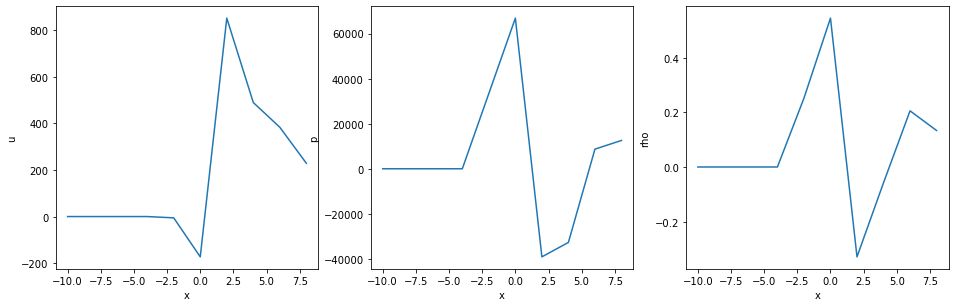

In [665]:
n_arr = np.array([10,20,40,80,160])
plt.figure(figsize=(16, 6))
for j in range(len(n_arr)):
    n = n_arr[j]
    g = 1.4
    x = np.linspace(-10,10,n+1)
    x1 = (x+10/n)[:n]
    p = 1e5*np.ones_like(x)
    rho = np.ones_like(x)
    u = 100*np.ones_like(x)
    for i in range(len(x)):
        if x[i]>0:
            p[i] = 1e4
            rho[i] = 0.125
            u[i] = 50
    dx = 20/n
    t = 0
    l = 0.0001
    while(t<0.01):
        t += dx*l
        p,rho,u = roe_2nd(p,rho,u,x1,l)
    plt.subplot(1,3,1,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.plot(x[:n],u[:n]-values['u'][::int(320/n)],label=n)
    plt.subplot(1,3,2,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('p')
    plt.plot(x[:n],p[:n]-values['p'][::int(320/n)],label=n)
    plt.subplot(1,3,3,box_aspect=1)
    plt.xlabel('x')
    plt.ylabel('rho')
    plt.plot(x[:n],rho[:n]-values['rho'][::int(320/n)],label=n)
plt.subplots_adjust(wspace=0.5)
plt.legend()
plt.show()

### Problem 4

The problem solving techniques involving 2nd order accuracy should have lesser error as compared to those with 1st order accuracy.